In [35]:
#!/usr/bin/env python
# coding: utf-8

In[4]:

Import necessary libraries

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from pymor.algorithms.pod import pod
from scipy import signal

In [37]:
from pymor.vectorarrays.interface import VectorArray
from pymor.vectorarrays.numpy import NumpyVectorSpace

# POD Implementation - Linear and Non-Linear System
Recall the Principle of Orthogonal Decomposition (POD) for Linear Systems.
For Linear Time-Invariant (LTI) systems, the Ordinary Differential Equation (ODE) is represented by:

$$
\dot x = Ax  + Bu; \quad y= Cx+Du
$$


%

Function to generate a stable random state-space model

In [38]:
def generate_stable_state_space(n):
    # Generate a diagonal matrix with negative eigenvalues for stability
    A = np.diag(-np.random.rand(n))
    
    # Generate random B, C, D matrices
    B = np.random.rand(n, 1)
    C = np.random.rand(1, n)
    D = np.array([[0]])  # Often zero for physical systems
    
    # Create state-space model
    sys = signal.StateSpace(A, B, C, D)
    return sys

In[6]:

Generate Random Linear-Time Invariant (LTI) System

In [39]:
n = 1000
np.random.seed(2)

Generate a stable state-space model

In [40]:
sys = generate_stable_state_space(n)
A, B, C, D = sys.A, sys.B, sys.C, np.zeros((sys.C.shape[0], sys.B.shape[1]))

## Introducing Non-Linearities
In this section, we introduce a non-linearity to the system.


In[71]:

Nonlinearity

In [41]:
alpha = 10
def f(x):
    return np.array(alpha * np.exp(-0.1 * x))

Input function

In [42]:
inp = 1
u = lambda t: 20*np.cos(10*t) if inp == 1 else np.exp(-t) * np.cos(np.pi * t)

## Generating Snapshots
Now, we'll simulate the original system to generate snapshot data.


In[123]:

Define the new ODE function with non-linearity

In [43]:
def dx(t, x, A=A, B=B):
    z = (A @x).reshape(-1,1) + f(x).reshape(-1,1) + B*u(t)         
    return z.flatten()

In[ ]:

Define simulation parameters

In [44]:
t_start = 0
t_final = 10
time = np.linspace(t_start, t_final, 200)

Initial condition

In [45]:
x0 = np.zeros(n)

Simulate the original system

In [46]:
sol = solve_ivp(dx, (t_start, t_final), x0, t_eval=time)

Store snapshots

In [47]:
X = sol.y

In[119]:

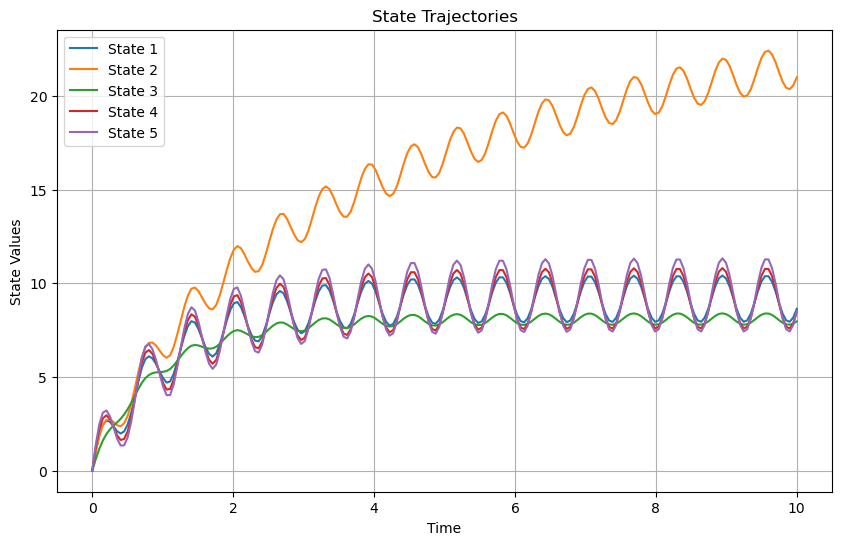

In [48]:
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(time, X[i, :], label=f'State {i+1}')
plt.title('State Trajectories')
plt.xlabel('Time')
plt.ylabel('State Values')
plt.legend()
plt.grid(True)
plt.show()

## Performing POD
In this section, we'll use the `pod` function from PyMor to perform the reduction.


##### Convert the data-type of the snapshots to use PYMOR

In [58]:
space = NumpyVectorSpace(len(X))
snapshots_array = space.make_array(np.array(X).T)

##### Select ROM Dimension

In [59]:
rom_dimension = 4

Perform POD

03:10 pod: Computing SVD ...
03:10 |   method_of_snapshots: Computing Gramian (200 vectors) ...
03:10 |   method_of_snapshots: Computing eigenvalue decomposition ...
03:10 |   method_of_snapshots: Computing left-singular vectors (4 vectors) ...
03:10 pod: Checking orthonormality ...


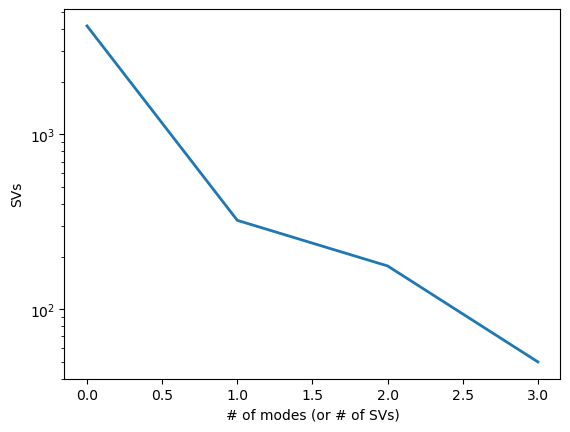

In [51]:
modes, singular_values = pod(snapshots_array, modes=rom_dimension)
modes = modes.to_numpy()
modes = modes.T
# Plot singular values
plt.figure()
plt.semilogy(singular_values, linewidth=2)
plt.xlabel('# of modes (or # of SVs)')
plt.ylabel('SVs')
plt.show()

## Building and Simulating the Reduced-Order Model
Now, we'll build the reduced-order model using the modes obtained from POD, and then simulate the reduced system.


In[20]:

Project onto POD modes

In [52]:
Ar = modes.T @ A @ modes
Br = modes.T @ B
Cr = C @ modes
Dr = D

%
Initial Condition on reduced space

In [53]:
z0 = modes.T @ x0

%
Define the new ODE function for reduced system

In [54]:
def dxPOD(t, z, Ar=Ar, Br=Br):
    z = (Ar @z).reshape(-1,1) + (modes.T@(f(modes@z).reshape(-1,1))).reshape(-1,1) + Br*u(t)         
    return z.flatten()

Simulate the reduced-order model

In [55]:
sol_rom = solve_ivp(dxPOD, (t_start, t_final), z0, t_eval=time)

%
Plot the results

In [56]:
yr_POD_NL = Cr @ sol_rom.y
yr_POD_NL_recons = modes @ sol_rom.y

%

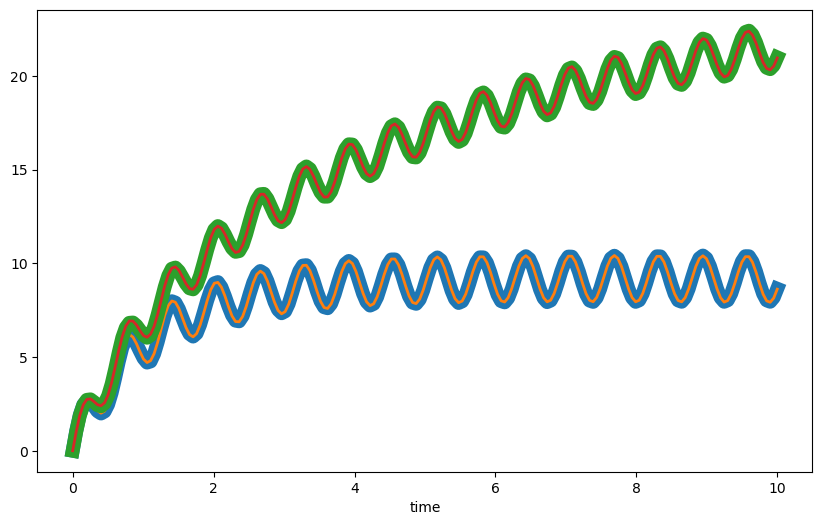

In [57]:
plt.figure(figsize=(10, 6))
for i in range(2):
    plt.plot(time, X[i, :], label=f'State {i+1}',linewidth=10)
    plt.plot(sol_rom.t, yr_POD_NL_recons[i,:], linewidth=2)
    
plt.xlabel('time')
plt.show()